# Time Series Analysis - Dogecoin price
If you are in any way involved with investing, there is a good chance that you have heard about Dogecoin and why it is gaining popularity over the past few months. For those that have not, Dogecoin is a cryptocurrency that was first introduced towards the end of 2013. For most of the time that it has been on the market, the currency has existed as a sort of a joke due to its name and its measly value of about $0.001.

However, in the space of a year the cryptocurrency has increased in value by around <strong>32000%</strong>. 
Such a drastic increase in price has taken place following various tweets from Elon Musk and various other celebrities, as well as promtional campaigns all over social media. 
Currently, Dogecoin sits at about 0.58 dollars as it continues its surge towards the community goal of $1.

In this notebook, I will attempt to create a predictive model for the price of Dogecoin and how it will change in the future.

In [79]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Read in data and set the 'Date' column as the index
dc = pd.read_csv('dogecoin_may.csv', index_col='Date', parse_dates=True)
dc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0


In [81]:
# Inspect basic information about data types in the dataframe
dc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2425 entries, 2014-09-17 to 2021-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2421 non-null   float64
 1   High       2421 non-null   float64
 2   Low        2421 non-null   float64
 3   Close      2421 non-null   float64
 4   Adj Close  2421 non-null   float64
 5   Volume     2421 non-null   float64
dtypes: float64(6)
memory usage: 132.6 KB


In [82]:
# Looking above, we have 4 rows that have missing values so we get rid of them
dc = dc.dropna()
dc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2421 entries, 2014-09-17 to 2021-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2421 non-null   float64
 1   High       2421 non-null   float64
 2   Low        2421 non-null   float64
 3   Close      2421 non-null   float64
 4   Adj Close  2421 non-null   float64
 5   Volume     2421 non-null   float64
dtypes: float64(6)
memory usage: 132.4 KB


In [110]:
# Most recent data point
dc.iloc[-1]

Open         5.829300e-01
High         5.956930e-01
Low          5.203420e-01
Close        5.710640e-01
Adj Close    5.710640e-01
Volume       2.054540e+10
Name: 2021-05-07 00:00:00, dtype: float64

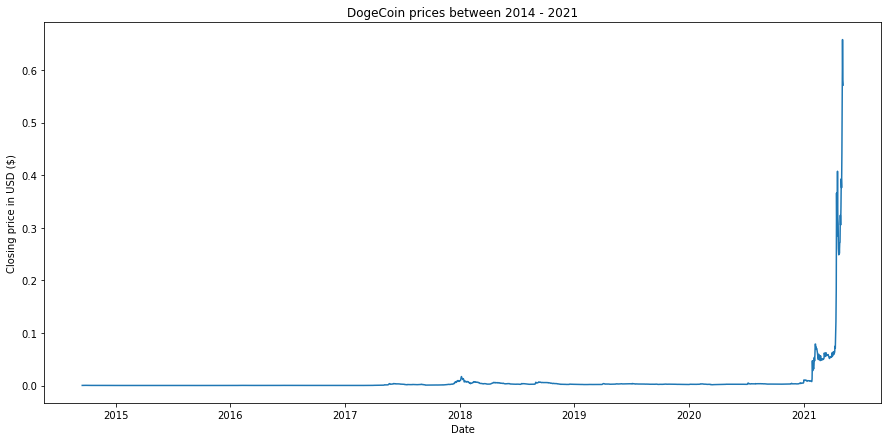

In [83]:
# Observational plot of closing price over the past few years
plt.figure(figsize=(15,7))
plt.plot(dc.index, dc['Close'])
plt.title('DogeCoin prices between 2014 - 2021')
plt.xlabel('Date')
plt.ylabel('Closing price in USD ($)')
plt.show()

## Stationarity tests and transforming data
Before we can perform any sort of analysis on our data, it is crucial that we ensure that our data is stationary. Stationarity is a measure of how dependent the properties of a time series are on time. In order to perform any sorts of analysis it is important that we ensure that our data is stationary since it would be hard to model its behavior if it is constantly changing.

In order to test stationarity, we will use the Augmented Dickey-Fuller test which tests the null hypothesis that the time series is not stationary. From its results, we obtain the ADF test statistic and the p-value. In order to reject the null hypothesis that the series is not stationary, we require the p-value to be less than 0.05 and we also look for the ADF statistic to be as negative as possible.

In [84]:
# First ADF test with no transformation on data
adf_test1 = adfuller(dc['Close'])
print('The value for the ADF statistic is: {}'.format(adf_test1[0]))
print('The p-value is: {}'.format(adf_test1[1]))

The value for the ADF statistic is: 7.878046550929383
The p-value is: 1.0


Looking at the results of the first ADF test, we notice that both of our statistics do not satisfy the requirements for rejecting the null hypothesis. This is also visible from the plot above which clearly shows a trend in our data. For our next step, we will take the difference between the prices which is a common technique when it comes to transforming data for it to become stationary.

In [85]:
# Second ADF test. Data has been transformed by taking the difference
# between closing prices
adf_test2 = adfuller(dc['Close'].diff().dropna())
print('The value for the ADF statistic is: {}'.format(adf_test2[0]))
print('The p-value is: {}'.format(adf_test2[1]))

The value for the ADF statistic is: -2.56807151380583
The p-value is: 0.09977740742502733


With the second test, we find a negative ADF statistic value but our p-value is not low enough for it to be statistically significant. Hence, we chose to take another difference in our third test.

In [86]:
# Third ADF test. Data has been transformed by taking the second difference
# between closing prices
adf_test3 = adfuller(dc['Close'].diff().diff().dropna())
print('The value for the ADF statistic is: {}'.format(adf_test3[0]))
print('The p-value is: {}'.format(adf_test3[1]))

The value for the ADF statistic is: -13.618189666123767
The p-value is: 1.817949282746191e-25


With our third test, we find that both statistics satisfy the conditions for rejecting the null hypothesis. Thus, moving forward we will be working with the second difference of closing prices of Dogecoin.

## Building the model
We will be using the ARIMA model to model our data.
1. AR stands for Autoregression, which describes a model that has a variable that regresses on its own past values.
2. I stands for Integrated, which describes the differencing that occurs to make the data stationary.
3. MA which stands for Moving average, which describes the incorporation of the dependency between an observation and a residual error.
In order to build this model, we need to determine some parameters which we do by performing the ACF and PCAF test. The ACF is the auto-correlation function and when we plot it we look for the lag value after which the values start to decrease constantly. Similarly, the PCAF is the partial auto-correlation function for which we also do the same. To read more about the two, click [here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8).

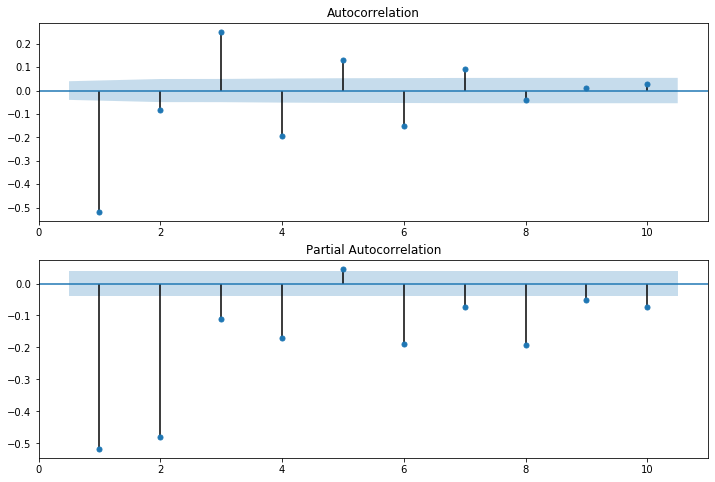

In [87]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF and PACF
plot_acf(dc['Close'].diff().diff().dropna(), lags=10, zero=False, ax=ax1)
plot_pacf(dc['Close'].diff().diff().dropna(), lags=10, zero=False, ax=ax2)

# Show plot
plt.show()

By observing the above plots, we find that a value of 3 can be obtained by the ACF plot and a value of 2 can be obtained from the second since we see an overall decrease after these points. However, just to be sure we will perform another test using the AIC and BIC values. The Alkaike Information Criterion and the Bayseian Information Criterion are both criterion for judging the performance of a model. In order to choose the best model, we look for the highest relative values for both values.

In [88]:
# Second test using AIC and BIC values
# Loop over p values from 0-3
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
      try:
        # Create and fit ARMA(p,q) model
        model = SARIMAX(dc['Close'].diff().diff().dropna(), order=(p,0,q), trend='c')
        results = model.fit()
        
        # Print p, q, AIC, BIC
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

0 0 -15621.62564736285 -15610.043428341629
0 1 -17345.332960365624 -17327.959631833794
0 2 -17268.09249316773 -17244.92805512529
0 3 -17208.982419044354 -17180.026871491304
1 0 -16390.578111705774 -16373.204783173944
1 1 -17129.82916623437 -17106.66472819193
1 2 -17422.506114444077 -17393.550566891026
1 3 -17249.969202961995 -17215.222545898334
2 0 -17070.010844332955 -17046.846406290515
2 1 -17141.945838048356 -17112.990290495305
2 2 -17322.6322976457 -17287.88564058204
2 3 -17485.060365947924 -17444.522599373653
3 0 -17110.81605000731 -17081.86050245426
3 1 -17166.03580874905 -17131.28915168539
3 2 -17517.346577897264 -17476.808811322993
3 3 -17464.818722009513 -17418.489845924632


After observing the results, we find that the model that uses the parameters 3 and 2 performs the best. This solidifies our observations from earlier and we can now build the model.

In [89]:
# Build ARIMA model using p = 3, q = 2
# Difference is left as 0 since we already use the difference for input
model = SARIMAX(dc['Close'].diff().diff().dropna(), order=(3,0,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2419
Model:               SARIMAX(3, 0, 2)   Log Likelihood                8797.838
Date:                Fri, 07 May 2021   AIC                         -17583.676
Time:                        22:57:17   BIC                         -17548.930
Sample:                             0   HQIC                        -17571.041
                               - 2419                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7523      0.006   -134.200      0.000      -0.763      -0.741
ar.L2         -0.0375      0.005     -6.991      0.000      -0.048      -0.027
ar.L3          0.2350      0.005     50.864      0.000       0.226       0.244
ma.L1         -0.2040      0.006    -34.680      0.000      -0.216      -0.193
ma.L2         -0.7503      0.005   -160.699      0.000      -0.759      -0.741
sigma2      4.111e-05      1e-07    409.370      0.000    4.09e-05    4.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):          11722796.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):          684633.08   Skew:                             8.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       343.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

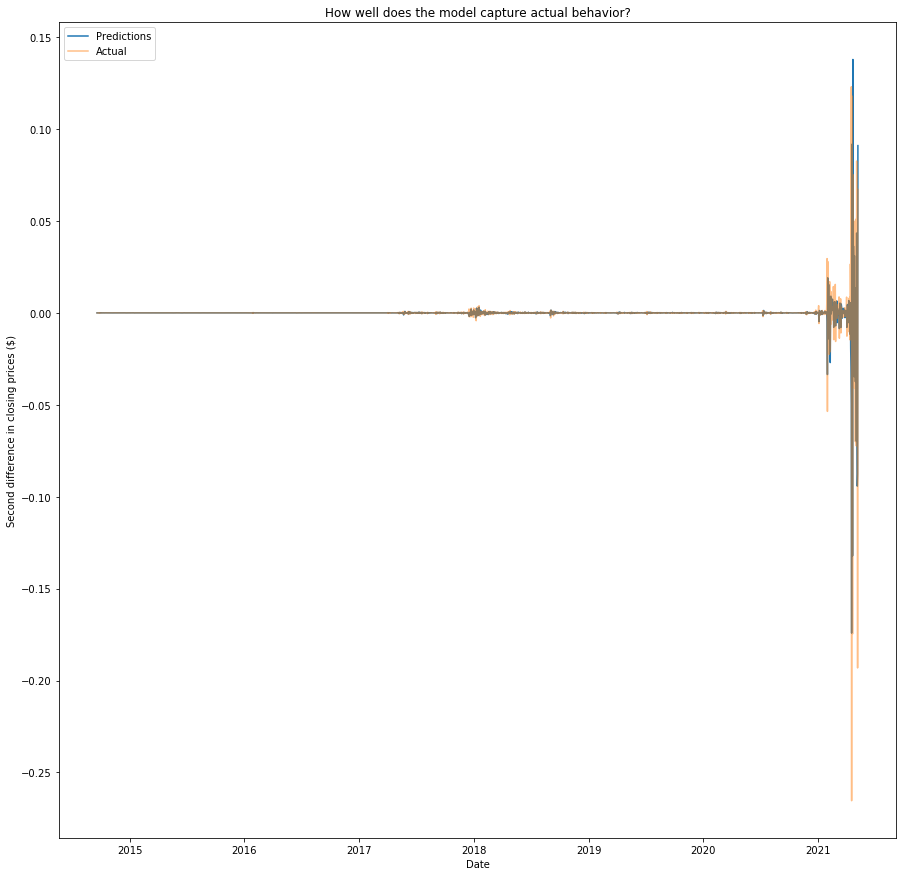

In [94]:
# Generate predictions for past data in order
# to compare model behavior and actual data
osp = result.get_prediction()
me = osp.predicted_mean
plt.figure(figsize=(15,15))
plt.plot(me.index, me.values)
plt.plot(dc.index[2:], dc.Close.diff().diff().dropna(), alpha=0.5)
plt.title('How well does the model capture actual behavior?')
plt.xlabel('Date')
plt.ylabel('Second difference in closing prices ($)')
plt.legend(['Predictions', 'Actual'])

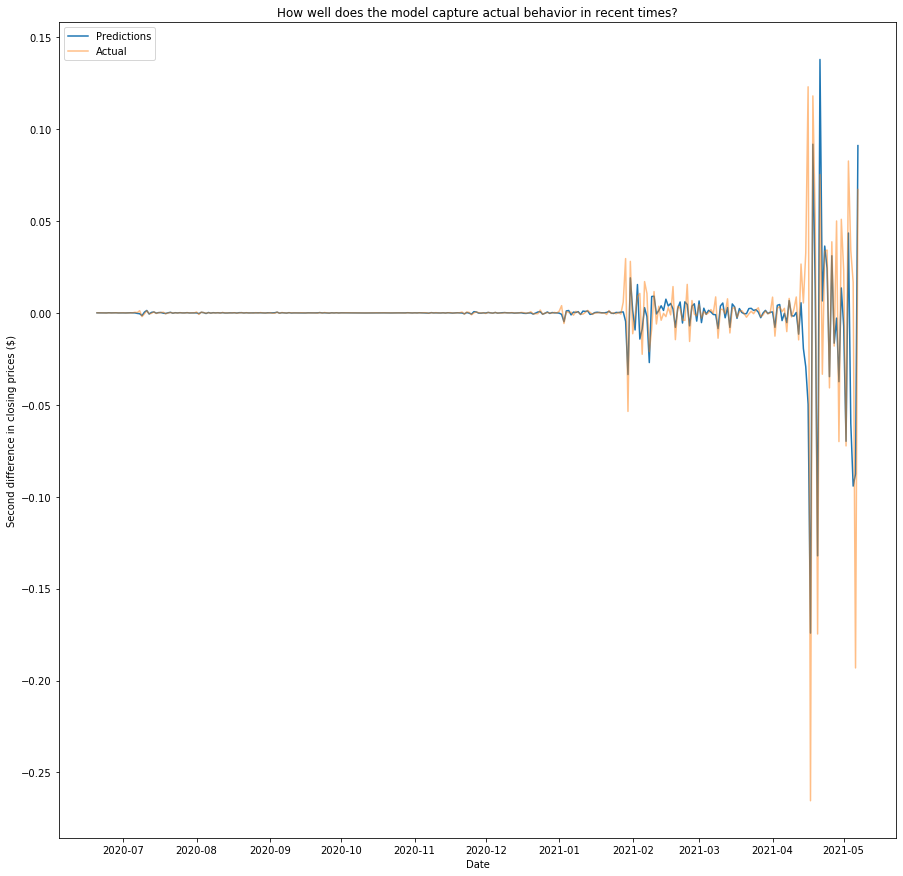

In [100]:
# Compare model behavior vs actual trends in 
# recent times
plt.figure(figsize=(15,15))
plt.plot(me.index[2100:], me.values[2100:])
plt.plot(dc.index[2102:], dc.Close.diff().diff().dropna()[2100:], alpha=0.5)
plt.title('How well does the model capture actual behavior in recent times?')
plt.xlabel('Date')
plt.ylabel('Second difference in closing prices ($)')
plt.legend(['Predictions', 'Actual'])

Looking at both the plots above, we see that our model does a pretty good job modeling the behavior of the data even though we do not have that much data. Now, we can try and make some predictions for the future.

In [114]:
# Generate predictions for the next 10 days
fore = result.get_forecast(steps=10).predicted_mean

# Transform second difference back to price
test = np.cumsum(fore)
fin = test + dc['Close'].iloc[-1]
print('According to our model, the price of dogecoin from May 8th to 17th will close at {}.'.format(fin.values))

According to our model, the price of dogecoin from May 8th to 17th will close at [0.61579016 0.55216262 0.61411937 0.58040452 0.58849292 0.59823204
 0.58267872 0.59591538 0.58882911 0.59000884].


## Notes

Moving forward, I aim to insert data from social media such as tweets/day on dogecoin and see how that impacts the behavior of our model and if it can improve our model.